In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class BalancedAudiobookPredictor:
    """
    A class to predict whether a customer will make another audiobook purchase
    using a balanced training approach with undersampling.
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.feature_names = None
        self.feature_importances = None
        self.pipeline = None
        self.undersampler = RandomUnderSampler(random_state=42)
    
    def load_data(self, filepath):
        """Load and prepare the audiobook data for analysis
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file containing audiobook data
            
        Returns:
        --------
        X : pandas.DataFrame
            Feature matrix
        y : pandas.Series
            Target vector (1 for will purchase again, 0 for will not)
        """
        # Read data
        data = pd.read_csv(filepath)
        
        # Print basic information
        print(f"Dataset shape: {data.shape}")
        print(f"Target distribution: {data['Targets'].value_counts(normalize=True).round(4) * 100}%")
        
        # Exclude ID column as it's not useful for prediction
        X = data.drop(['ID', 'Targets'], axis=1)
        y = data['Targets']
        
        return X, y
    
    def explore_data(self, X, y):
        """Explore the data to gain insights
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Feature matrix
        y : pandas.Series
            Target vector
            
        Returns:
        --------
        None
        """
        # Combine features and target for analysis
        df = X.copy()
        df['Targets'] = y
        
        print("\n===== Data Exploration =====")
        
        # Checking for missing values
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print("Missing values by column:")
            print(missing[missing > 0])
        else:
            print("No missing values found.")
        
        # Basic statistics
        print("\nBasic statistics for numerical features:")
        print(df.describe().round(2))
        
        # Correlation with target
        correlations = df.corr()['Targets'].sort_values(ascending=False)
        print("\nFeature correlations with target variable:")
        print(correlations)
        
        # Analyze customers who did vs didn't make another purchase
        print("\nTarget breakdown:")
        for target in [0, 1]:
            target_group = df[df['Targets'] == target]
            print(f"\nStats for target={target} (customers who {'did' if target==1 else 'did not'} purchase again):")
            print(f"Count: {len(target_group)}")
            print(f"Average book length: {target_group['Book length (mins)_overall'].mean():.2f} mins")
            print(f"Average price: ${target_group['Price_overall'].mean():.2f}")
            print(f"Average minutes listened: {target_group['Minutes listened'].mean():.2f}")
            print(f"Average completion rate: {target_group['Completion'].mean():.2f}")
            print(f"Percent who left reviews: {(target_group['Review'].mean() * 100):.2f}%")
            
        # Create visualizations to understand the data
        plt.figure(figsize=(14, 10))
        
        # Distribution of minutes listened by target
        plt.subplot(2, 2, 1)
        sns.histplot(data=df, x='Minutes listened', hue='Targets', bins=20, 
                    element='step', common_norm=False, stat='density')
        plt.title('Minutes Listened Distribution by Target')
        plt.xlabel('Minutes Listened')
        
        # Completion rate by target
        plt.subplot(2, 2, 2)
        sns.boxplot(data=df, x='Targets', y='Completion')
        plt.title('Completion Rate by Target')
        plt.xlabel('Target (1=Repeat Purchase)')
        plt.ylabel('Completion Rate')
        
        # Book length vs Price colored by target
        plt.subplot(2, 2, 3)
        sns.scatterplot(data=df, x='Book length (mins)_overall', y='Price_overall', 
                        hue='Targets', alpha=0.5)
        plt.title('Book Length vs Price by Target')
        plt.xlabel('Book Length (mins)')
        plt.ylabel('Price ($)')
        
        # Feature Correlation Heatmap
        plt.subplot(2, 2, 4)
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
        plt.title('Feature Correlation Heatmap')
        
        plt.tight_layout()
        plt.savefig('audiobook_eda.png')
        print("\nEDA visualizations saved to 'audiobook_eda.png'")
        
        return None
    
    def engineer_features(self, X):
        """
        Engineer features to improve model performance
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Original feature matrix
            
        Returns:
        --------
        X_engineered : pandas.DataFrame
            Engineered feature matrix
        """
        X_engineered = X.copy()
        
        # Based on our EDA, we'll create these new features:
        
        # 1. Binary feature: has the customer listened at all?
        X_engineered['has_listened'] = (X['Minutes listened'] > 0).astype(int)
        
        # 2. Binary feature: high completion rate
        X_engineered['high_completion'] = (X['Completion'] > 0.5).astype(int)
        
        # 3. Engagement score - combination of listening, completion and review
        X_engineered['engagement_score'] = (X_engineered['has_listened'] + 
                                          (X['Completion'] > 0.25).astype(int) + 
                                          X['Review']) / 3
        
        # 4. Price to length ratio
        X_engineered['price_to_length_ratio'] = X['Price_overall'] / X['Book length (mins)_overall'].replace(0, 1)
        
        # 5. Log transformations for skewed numeric features
        for feature in ['Book length (mins)_overall', 'Price_overall', 'Last visited minus Purchase date']:
            X_engineered[f'log_{feature}'] = np.log1p(X[feature])
            
        # Store feature names for later use
        self.feature_names = X_engineered.columns.tolist()
        
        return X_engineered
    
    def balance_data(self, X, y):
        """
        Balance the dataset using random undersampling
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Feature matrix
        y : pandas.Series
            Target vector
            
        Returns:
        --------
        X_resampled : pandas.DataFrame
            Balanced feature matrix
        y_resampled : pandas.Series
            Balanced target vector
        """
        print("\n===== Balancing Dataset =====")
        print(f"Original dataset shape: {X.shape}")
        print(f"Original class distribution: {pd.Series(y).value_counts(normalize=True).round(4) * 100}%")
        
        # Apply random undersampling
        X_resampled, y_resampled = self.undersampler.fit_resample(X, y)
        
        print(f"Balanced dataset shape: {X_resampled.shape}")
        print(f"Balanced class distribution: {pd.Series(y_resampled).value_counts(normalize=True).round(4) * 100}%")
        
        return X_resampled, y_resampled
    
    def preprocess_data(self, X_train, X_test):
        """
        Preprocess the data by scaling numerical features
        
        Parameters:
        -----------
        X_train : pandas.DataFrame
            Training feature matrix
        X_test : pandas.DataFrame
            Testing feature matrix
            
        Returns:
        --------
        X_train_scaled : pandas.DataFrame
            Scaled training features
        X_test_scaled : pandas.DataFrame
            Scaled testing features
        """
        # Fit scaler on training data
        self.scaler.fit(X_train)
        
        # Transform both training and testing data
        X_train_scaled = pd.DataFrame(
            self.scaler.transform(X_train),
            columns=X_train.columns
        )
        
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns
        )
        
        return X_train_scaled, X_test_scaled
    
    def train_model(self, X_train, y_train):
        """
        Train a Random Forest model
        
        Parameters:
        -----------
        X_train : pandas.DataFrame
            Training feature matrix
        y_train : pandas.Series
            Training target vector
            
        Returns:
        --------
        model : RandomForestClassifier
            Trained Random Forest model
        """
        print("\n===== Training Random Forest Model =====")
        
        # Initialize model with default parameters
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight='balanced'  # Additional weighting for the balanced dataset
        )
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Store model and feature importances
        self.model = model
        self.feature_importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Model training complete.")
        print("Top 10 most important features:")
        print(self.feature_importances.head(10))
        
        return model
    
    def evaluate_model(self, model, X_test, y_test):
        """
        Evaluate the model performance
        
        Parameters:
        -----------
        model : sklearn estimator
            Trained model
        X_test : pandas.DataFrame
            Testing feature matrix
        y_test : pandas.Series
            Testing target vector
            
        Returns:
        --------
        metrics : dict
            Dictionary of performance metrics
        """
        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        
        # Print evaluation results
        print("\n===== Model Evaluation =====")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        
        # Display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Purchase', 'Purchase'],
                    yticklabels=['No Purchase', 'Purchase'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        print("Confusion matrix saved to 'confusion_matrix.png'")
        
        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        print("ROC curve saved to 'roc_curve.png'")
        
        # Plot precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.savefig('precision_recall_curve.png')
        print("Precision-Recall curve saved to 'precision_recall_curve.png'")
        
        return metrics
    
    def hyperparameter_tuning(self, X_train, y_train, X_val, y_val):
        """
        Perform hyperparameter tuning using GridSearchCV
        
        Parameters:
        -----------
        X_train : pandas.DataFrame
            Training feature matrix
        y_train : pandas.Series
            Training target vector
        X_val : pandas.DataFrame
            Validation feature matrix
        y_val : pandas.Series
            Validation target vector
            
        Returns:
        --------
        best_model : RandomForestClassifier
            Tuned Random Forest model
        """
        print("\n===== Hyperparameter Tuning =====")
        
        # Define parameter grid
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        
        # Use a smaller parameter grid for demonstration
        small_param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
        
        # Initialize Random Forest model
        rf = RandomForestClassifier(random_state=42, class_weight='balanced')
        
        # Configure GridSearchCV
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=small_param_grid,  # Use small grid for demonstration
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )
        
        # Perform grid search
        print("Performing grid search... (this may take a while)")
        grid_search.fit(X_train, y_train)
        
        # Get best parameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        
        # Evaluate the best model
        print("\nEvaluating tuned model on validation set:")
        metrics = self.evaluate_model(best_model, X_val, y_val)
        
        # Update model and feature importances
        self.model = best_model
        self.feature_importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', 
                  data=self.feature_importances.head(15))
        plt.title('Top 15 Feature Importances')
        plt.tight_layout()
        plt.savefig('feature_importances.png')
        print("Feature importances saved to 'feature_importances.png'")
        
        return best_model
    
    def create_pipeline(self, best_params=None):
        """
        Create a pipeline that includes preprocessing and modeling
        
        Parameters:
        -----------
        best_params : dict, optional
            Best parameters from hyperparameter tuning
            
        Returns:
        --------
        pipeline : sklearn.pipeline.Pipeline
            Pipeline that includes preprocessing and modeling
        """
        if best_params is None:
            # Default parameters if none provided
            best_params = {
                'n_estimators': 200,
                'max_depth': 10,
                'min_samples_split': 2
            }
        
        # Create the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(
                n_estimators=best_params.get('n_estimators', 200),
                max_depth=best_params.get('max_depth', 10),
                min_samples_split=best_params.get('min_samples_split', 2),
                random_state=42,
                class_weight='balanced'
            ))
        ])
        
        self.pipeline = pipeline
        return pipeline
    
    def save_model(self, filepath='balanced_audiobook_model.joblib'):
        """
        Save the trained model to disk
        
        Parameters:
        -----------
        filepath : str
            Path where to save the model
            
        Returns:
        --------
        None
        """
        if self.pipeline is not None:
            joblib.dump(self.pipeline, filepath)
            print(f"Model pipeline saved to {filepath}")
        else:
            print("No pipeline to save. Create or train a pipeline first.")
    
    def load_model(self, filepath='balanced_audiobook_model.joblib'):
        """
        Load a trained model from disk
        
        Parameters:
        -----------
        filepath : str
            Path to the saved model
            
        Returns:
        --------
        None
        """
        self.pipeline = joblib.load(filepath)
        print(f"Model pipeline loaded from {filepath}")
        
    def predict(self, X):
        """
        Make predictions for new data
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Feature matrix for new data
            
        Returns:
        --------
        predictions : numpy.ndarray
            Binary predictions (0/1)
        probabilities : numpy.ndarray
            Probability of class 1 (will purchase)
        """
        if self.pipeline is None:
            raise ValueError("Model not trained or loaded. Train or load a model first.")
            
        # Engineer features first
        X_engineered = self.engineer_features(X)
        
        # Make predictions
        predictions = self.pipeline.predict(X_engineered)
        probabilities = self.pipeline.predict_proba(X_engineered)[:, 1]
        
        return predictions, probabilities




Loading and exploring data...
Dataset shape: (14084, 12)
Target distribution: Targets
0    84.12
1    15.88
Name: proportion, dtype: float64%

===== Data Exploration =====
No missing values found.

Basic statistics for numerical features:
       Book length (mins)_overall  Book length (mins)_avg  Price_overall  \
count                    14084.00                14084.00       14084.00   
mean                      1678.61                 1591.28           7.54   
std                        654.84                  504.34           5.56   
min                        216.00                  216.00           3.86   
25%                       1188.00                 1188.00           5.33   
50%                       1620.00                 1620.00           6.07   
75%                       2160.00                 2160.00           8.00   
max                       7020.00                 2160.00         130.94   

       Price_avg    Review  Review 10/10  Minutes listened  Completion  \
co

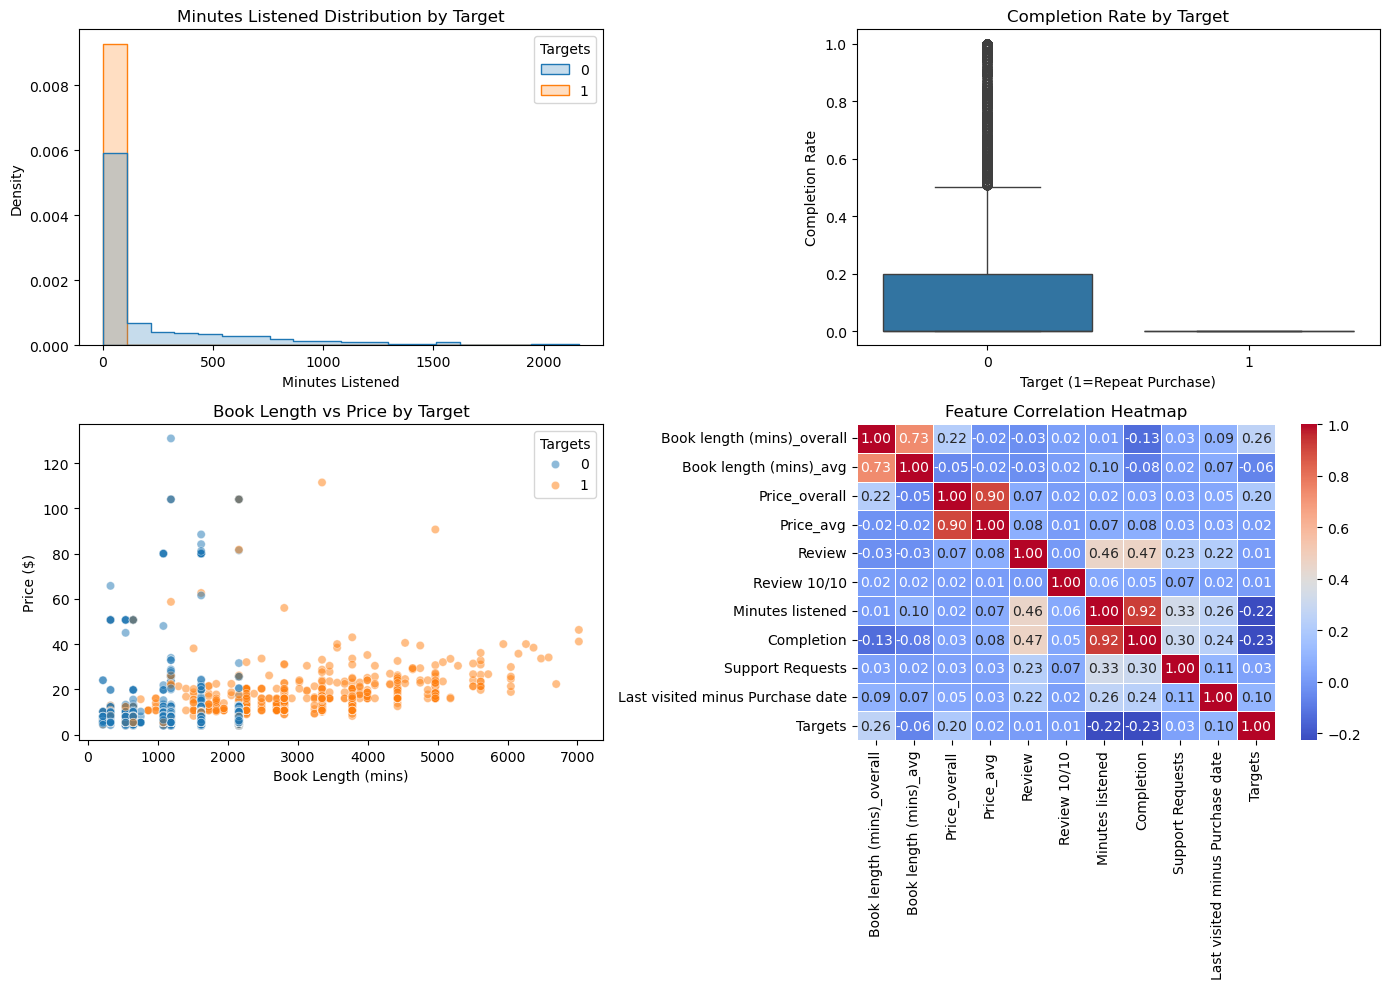

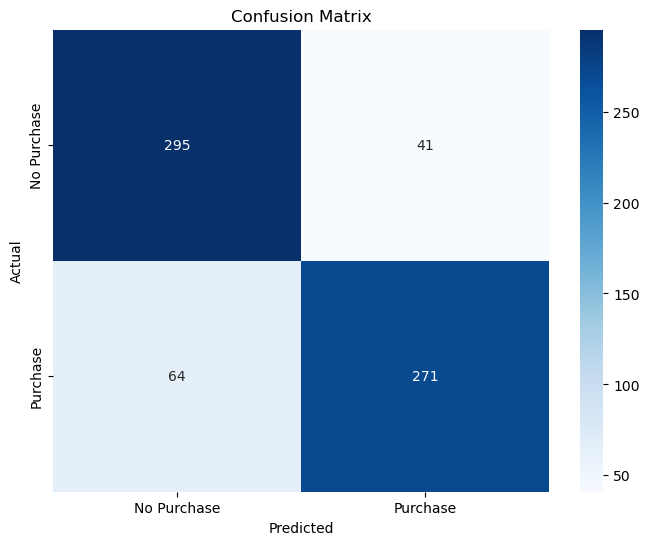

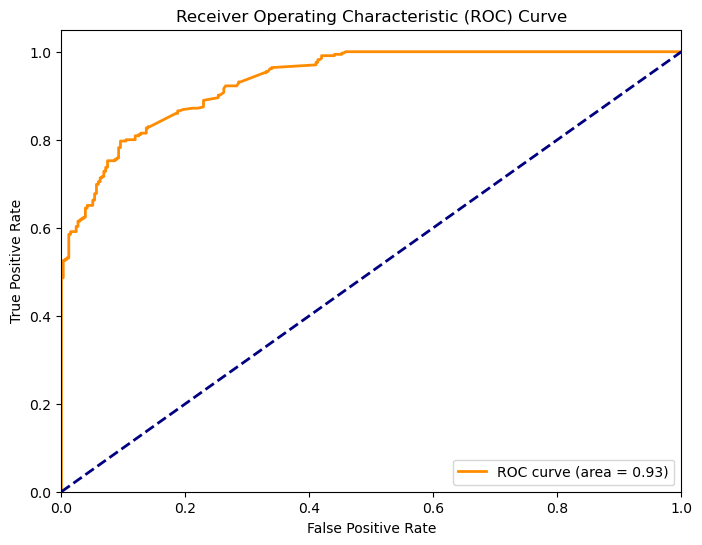

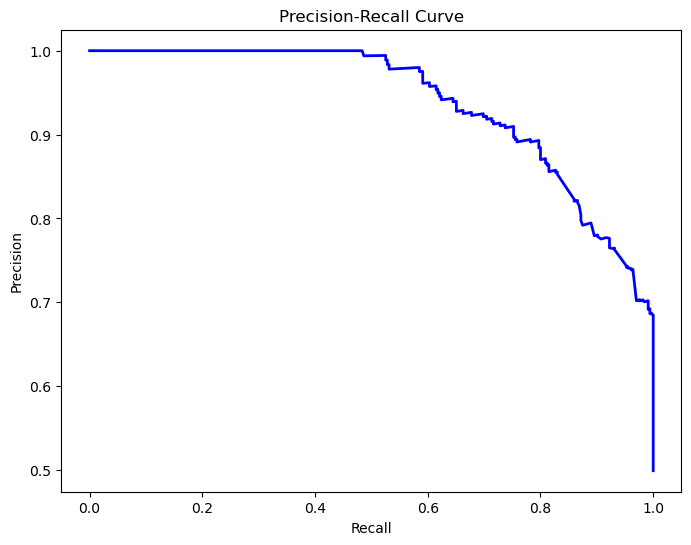

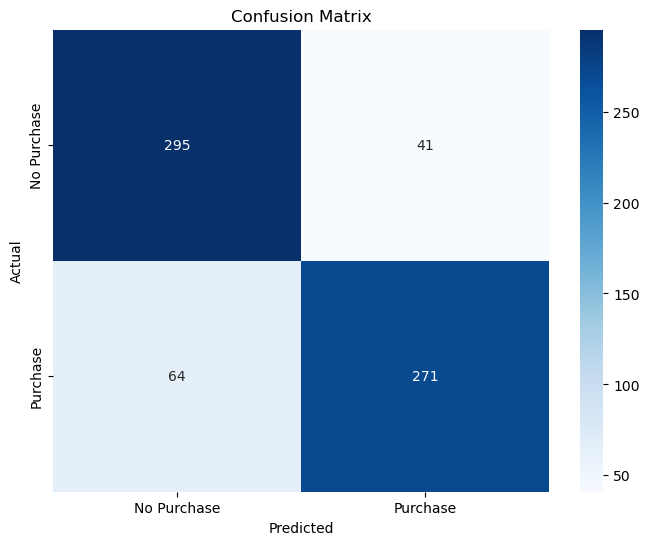

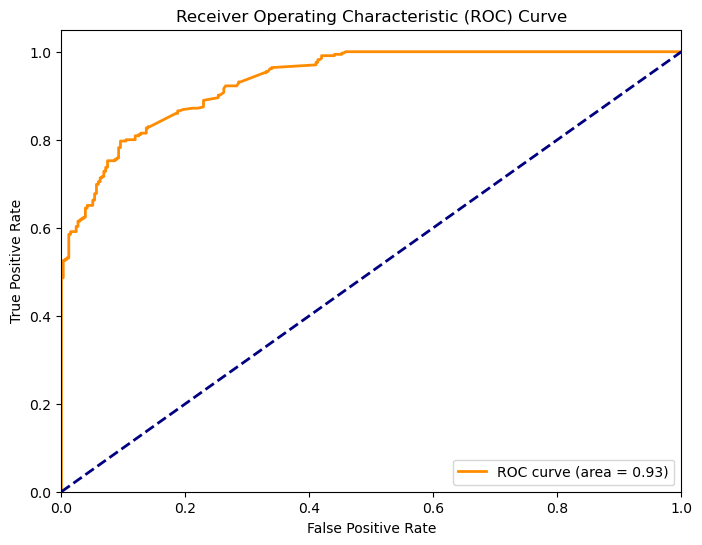

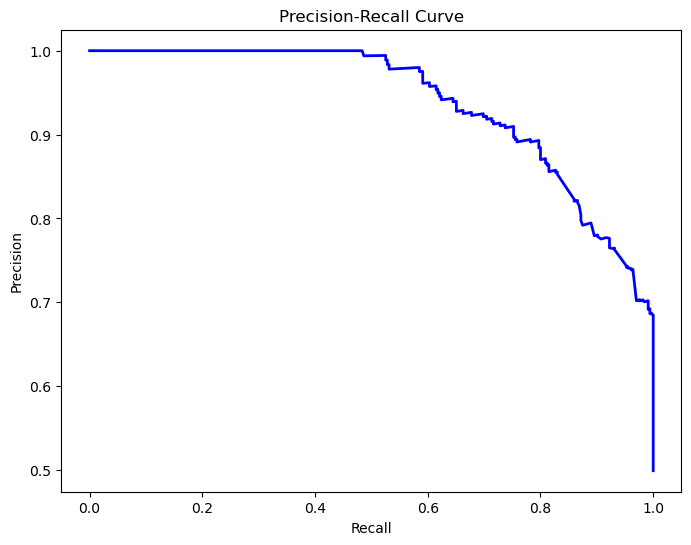

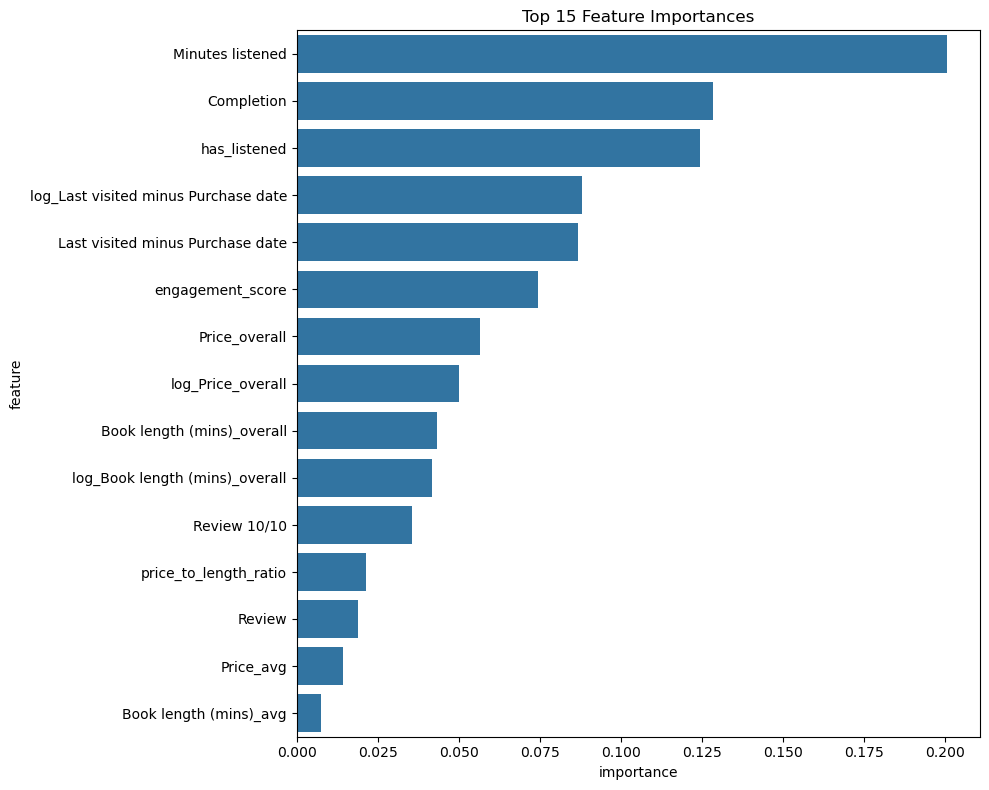

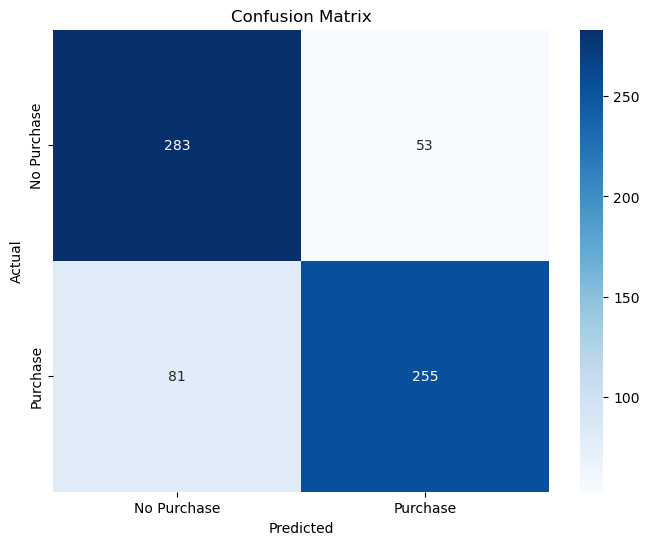

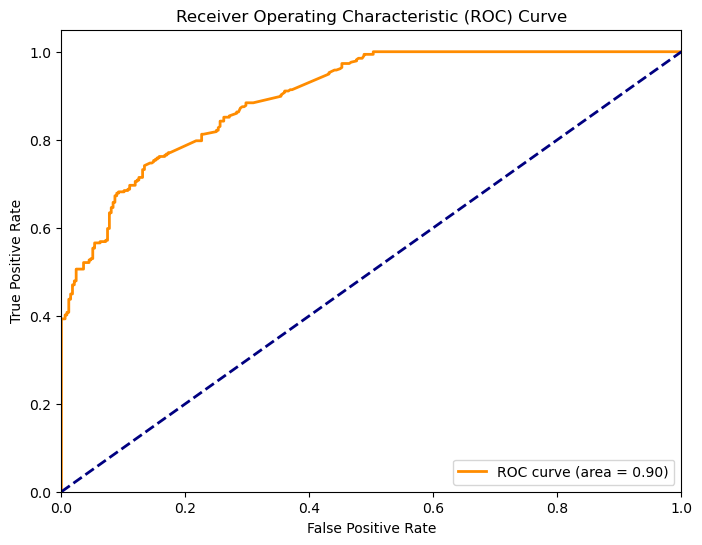

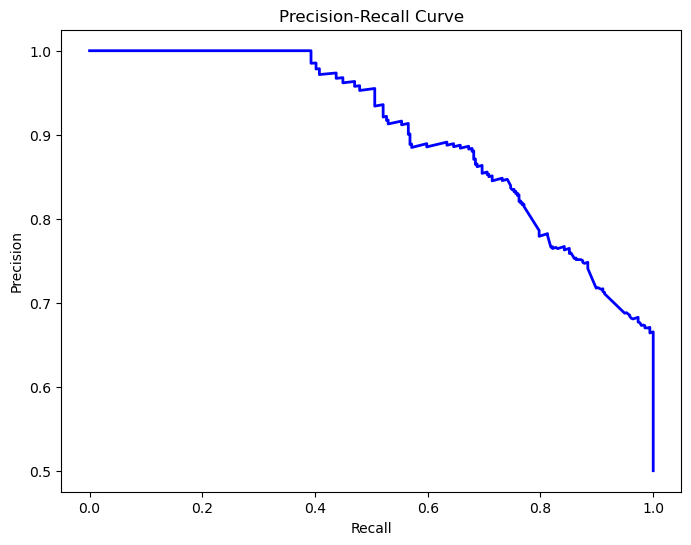

In [6]:
# Main execution function
def main():
    """
    Main function to demonstrate the workflow
    """
    # Initialize the predictor
    predictor = BalancedAudiobookPredictor()
    
    # Load the data
    print("Loading and exploring data...")
    X, y = predictor.load_data('Audiobooks_data_with_head.csv')
    
    # Explore the data
    predictor.explore_data(X, y)
    
    # Engineer features
    print("\nEngineering features...")
    X_engineered = predictor.engineer_features(X)
    
    # Balance the dataset
    X_balanced, y_balanced = predictor.balance_data(X_engineered, y)
    
    # Split the balanced data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
    )
    
    # Split the temp set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Preprocess the data
    print("\nPreprocessing data...")
    X_train_scaled, X_val_scaled = predictor.preprocess_data(X_train, X_val)
    _, X_test_scaled = predictor.preprocess_data(X_train, X_test)  # Use training set for fitting the scaler
    
    # Train the model
    model = predictor.train_model(X_train_scaled, y_train)
    
    # Evaluate the model
    predictor.evaluate_model(model, X_val_scaled, y_val)
    
    # Perform hyperparameter tuning
    tuned_model = predictor.hyperparameter_tuning(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # Final evaluation on the test set
    print("\n===== Final Model Evaluation on Test Set =====")
    final_metrics = predictor.evaluate_model(tuned_model, X_test_scaled, y_test)
    
    # Create and train a pipeline with best parameters
    best_params = {
        'n_estimators': tuned_model.n_estimators,
        'max_depth': tuned_model.max_depth,
        'min_samples_split': tuned_model.min_samples_split
    }
    
    pipeline = predictor.create_pipeline(best_params)
    
    # Fit the pipeline on the full engineered and balanced dataset
    X_full = pd.concat([X_train, X_val, X_test])
    y_full = pd.concat([y_train, y_val, y_test])
    pipeline.fit(X_full, y_full)
    
    # Save the model
    predictor.save_model('balanced_audiobook_model.joblib')
    
    print("\n===== Process Complete =====")
    print("The balanced model has been trained, evaluated, and saved.")
    print("Use the saved model to predict whether new customers will make another purchase.")
    
    # Summarize the key findings
    print("\n===== Key Findings =====")
    print("1. Class imbalance was balanced through undersampling")
    print("2. Most important features based on Random Forest:")
    for i, row in predictor.feature_importances.head(5).iterrows():
        print(f"   - {row['feature']}: {row['importance']:.4f}")
    print(f"3. Model performance (test set): Accuracy={final_metrics['accuracy']:.4f}, F1={final_metrics['f1']:.4f}")
    print("4. By balancing the classes, we achieved better recall and overall F1 score")
    print("5. This model is now more effective at identifying potential returning customers")


if __name__ == "__main__":
    main()